<a href="https://colab.research.google.com/github/BrandonYChan/Plant-Disease-Deep_Learning/blob/main/Ensemble_Plant_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Disease Classification Project

## Imports and Common Functions

In [4]:
# !pip install tensorflow-datasets
# !pip install tensorflow-hub
# !pip install gradio
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import keras
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from PIL import Image
import requests, os
import gradio

from keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report , roc_curve, roc_auc_score


# tf.__version__

In [5]:
# Dowload image from URL
def download_image(image_url, save_path='temp_image.jpg'):
    response = requests.get(image_url)
    if response.status_code == 200:
        with open(save_path, 'wb') as file:
            file.write(response.content)
        return save_path
    else:
        print(f'Failed to download image from URL: {image_url}')
        return None

# Build new models that use pretrained models as a base
def build_model(hub_url, input_shape=(224, 224, 3)):
    base_model = hub.KerasLayer(hub_url, trainable=True, input_shape=input_shape)
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model


In [6]:
# Return predicted disease
def predict_disease(image_source, model):
  # Check if image_source is a URL or a local path
  if image_source.startswith('http'):
      # Download the image if it's a URL
      image_path = download_image(image_source)
      if image_path is None:
          return None
  else:
      # Use the local path directly
      image_path = image_source

  # Load the image and preprocess it
  img = Image.open(image_path).convert('RGB')
  img = img.resize((224, 224))
  img = keras.preprocessing.image.img_to_array(img)
  img = img / 255
  img = tf.keras.applications.mobilenet_v3.preprocess_input(img)
  img = tf.expand_dims(img, axis=0)

  # Make the prediction
  prediction = model.predict(img)[0][0]
  predicted_class = 'Healthy' if prediction < 0.5 else 'Diseased'
  return predicted_class

## Dataset

In [7]:
# Load plant_leaves Dataset (Hosted Runtime)

# # Had to build manually for hosted runtime - Google Colab was having difficulty with tfds.load()
# dbuilder = tfds.builder('plant_leaves')
# dbuilder.download_and_prepare()
# split_ratio = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
# datasets = dbuilder.as_data_source(split=split_ratio)
# (train, validation, test), info = datasets, dbuilder.info
# print(info)

# # Convert to tensorflow dataset (loaded as array records type initially)
# def array_record_to_tf_dataset(array_record):
#     def generator():
#         for example in array_record:
#             yield example['image'], example['label']

#     return tf.data.Dataset.from_generator(
#         generator,
#         output_signature=(
#             tf.TensorSpec(shape=(None, None, 3), dtype=tf.uint8),
#             tf.TensorSpec(shape=(), dtype=tf.int64)
#         )
#     )

# # Convert splits to tensorflow dataset
# train = array_record_to_tf_dataset(train)
# validation = array_record_to_tf_dataset(validation)
# test = array_record_to_tf_dataset(test)

In [8]:
# Load plant_leaves Dataset (Local Runtime)

split_ratio = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
datasets, info = tfds.load('plant_leaves', with_info=True, split=split_ratio, as_supervised=True)
(train, validation, test) = datasets

In [9]:
# Preprocess data

def preprocess(image, label):
  image = tf.image.resize(image, (224, 224))
  image = image / 255.0
  # Assign binary classification (0/1 for healthy/diseased)
  label = tf.where(label < 12, 0, 1)
  return image, label

# Preprocess splits with batch mapping
train = train.batch(32).map(preprocess)
validation = validation.batch(32).map(preprocess)
test = test.batch(32).map(preprocess)

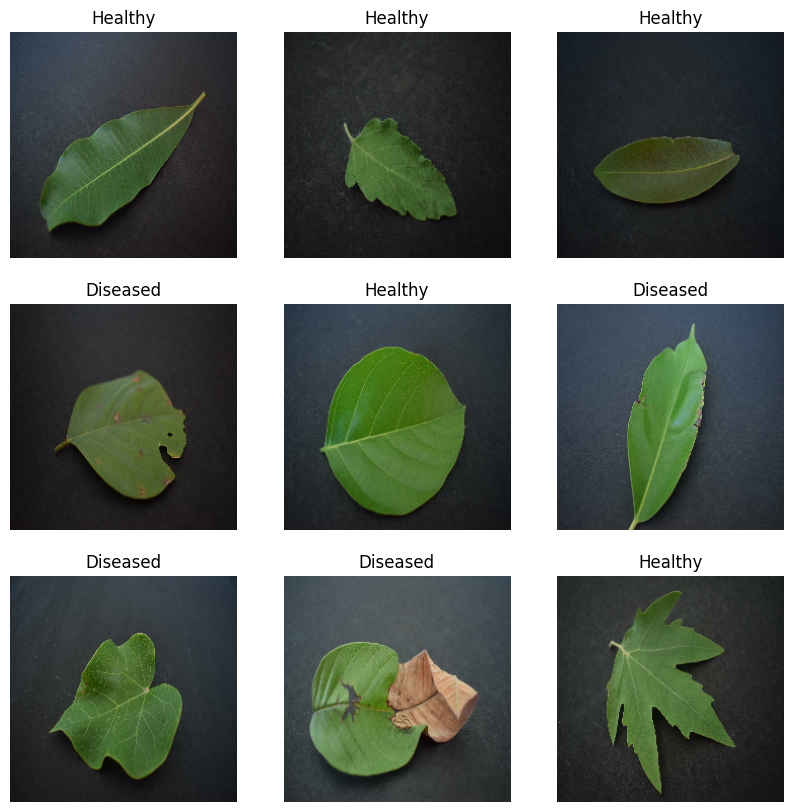

In [10]:
# Plot Examples
def plot_images(images, img_labels):
    plt.figure(figsize=(10, 10))
    for images, labels in train.take(1):
        images = images.numpy()
        labels = labels.numpy()
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i])
            plt.title(img_labels[int(labels[i])])
            plt.axis("off")
    plt.show()


plot_images(train, ['Healthy', 'Diseased'])

## Model 1: General Plant Disease Classifier

> Add blockquote



In [14]:
base1 = hub.KerasLayer('https://kaggle.com/models/rishitdagli/plant-disease/frameworks/TensorFlow2/variations/plant-disease/versions/1',  trainable=False)
model1 = keras.models.Sequential([
    keras.Input(shape=(224, 224, 3)),
    keras.layers.Lambda(lambda x: base1(x)),
    keras.layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model1.keras', monitor='val_loss', save_best_only=True), # Change file extension to .keras
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
]
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history1 = model1.fit(train, validation_data=validation, epochs=10, callbacks=callbacks)

model1.load_weights('best_model1.keras')

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6590 - loss: 0.6261 - val_accuracy: 0.5956 - val_loss: 0.6443
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.7390 - loss: 0.5044 - val_accuracy: 0.6422 - val_loss: 0.6152
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.7493 - loss: 0.4953 - val_accuracy: 0.7511 - val_loss: 0.5663
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.7631 - loss: 0.4859 - val_accuracy: 0.8022 - val_loss: 0.5162
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.7545 - loss: 0.4833 - val_accuracy: 0.7911 - val_loss: 0.4856
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.7579 - loss: 0.4753 - val_accuracy: 0.7978 - val_loss: 0.4491
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - accuracy: 0.7781 - loss: 0.4608 - val_accuracy: 0.7933 - val_loss: 0.4388
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.7702 - loss: 0.4548 - val_accu

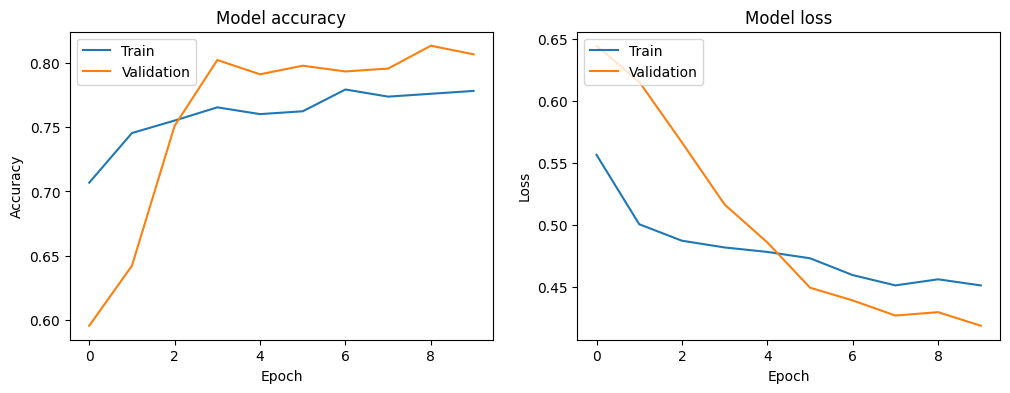

In [15]:
# Model Accuracy and Loss During Training

plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


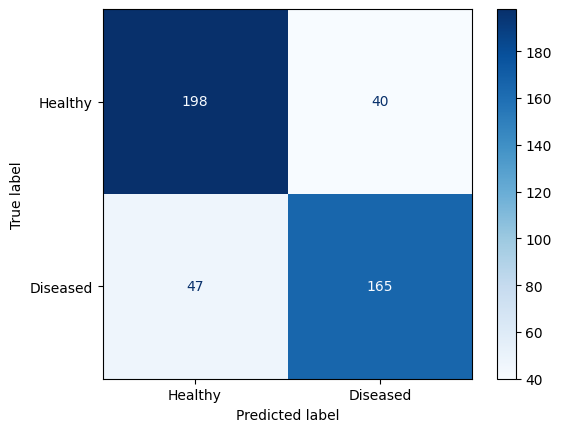

In [16]:
# Confusion matrix

y_true = []
y_pred = []

for image, label in test:
    y_true.extend(label.numpy())
    predictions = model1.predict(image)
    y_pred.extend(tf.round(predictions).numpy().flatten())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Diseased'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


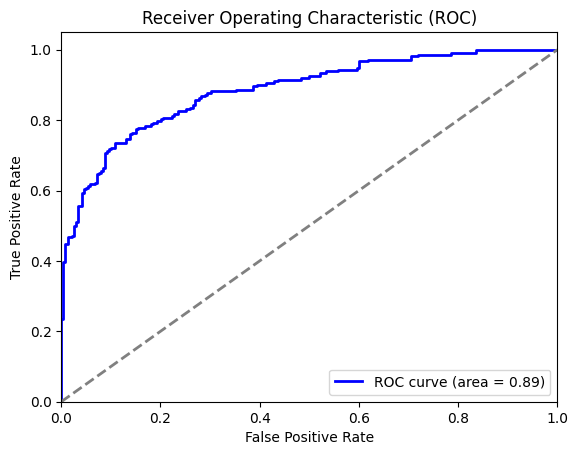

In [17]:
# ROC and AUC

y_true = []
y_pred_prob = []

for image, label in test:
    y_true.extend(label.numpy())
    predictions = model1.predict(image)
    y_pred_prob.extend(predictions.flatten())

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Model 2: Cassava Disease Classifier Based on Cropnet

In [19]:
# Load the model
base2 = hub.KerasLayer('https://tfhub.dev/google/cropnet/classifier/cassava_disease_V1/2' ,  trainable=False)
model2 = keras.models.Sequential([
    keras.layers.Lambda(lambda x: base2(x)),
    keras.layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model2.keras', monitor='val_loss', save_best_only=True)
]
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(train, validation_data=validation, epochs=5, callbacks=callbacks)

model2.load_weights('best_model2.keras')

Epoch 1/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.5246 - loss: 0.7556 - val_accuracy: 0.4244 - val_loss: 0.6970
Epoch 2/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step - accuracy: 0.5399 - loss: 0.7077 - val_accuracy: 0.4244 - val_loss: 0.7507
Epoch 3/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.5424 - loss: 0.6993 - val_accuracy: 0.4244 - val_loss: 0.7524
Epoch 4/5
113/113 ━━━━━━━━━━━━━━━━━━━━ 165s 1s/step - accuracy: 0.5442 - loss: 0.7012 - val_accuracy: 0.4267 - val_loss: 0.7308


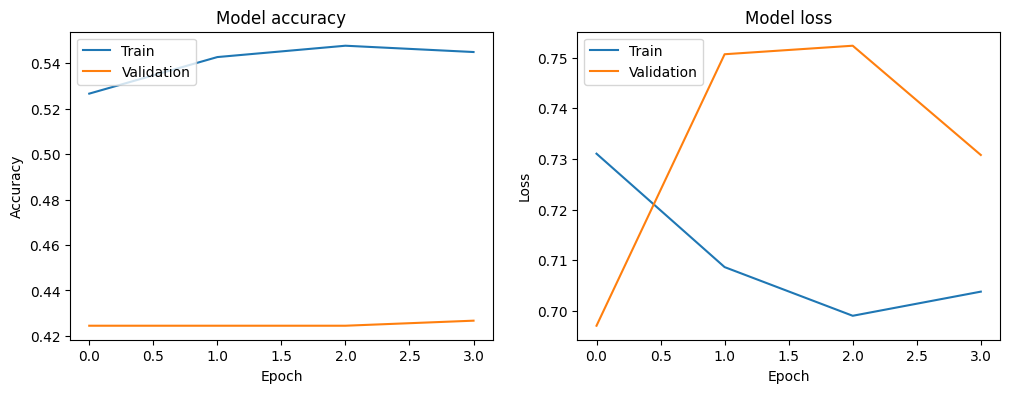

In [20]:
# Model Accuracy and Loss During Training

plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


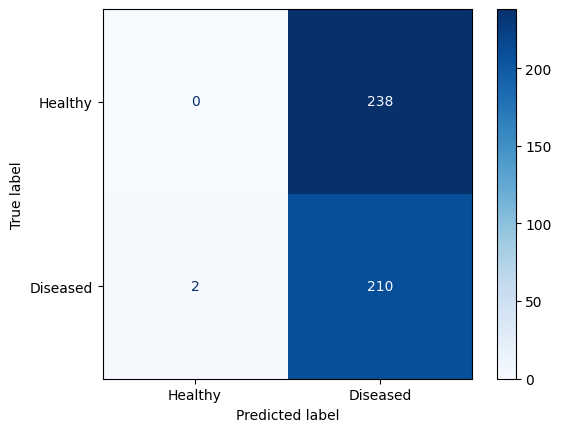

In [21]:
# Confusion matrix

y_true = []
y_pred = []

for image, label in test:
    y_true.extend(label.numpy())
    predictions = model2.predict(image)
    y_pred.extend(tf.round(predictions).numpy().flatten())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Diseased'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 711ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


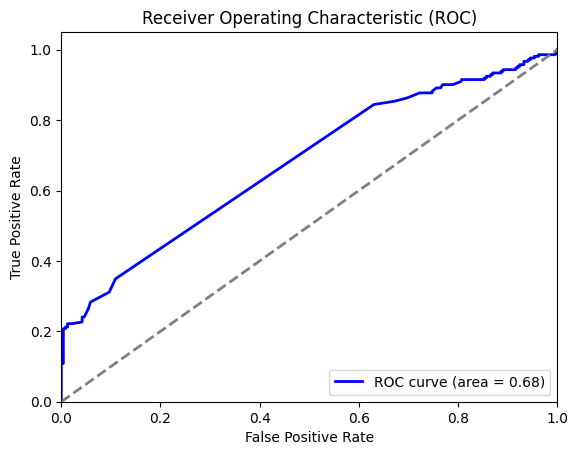

In [22]:
# ROC and AUC

y_true = []
y_pred_prob = []

for image, label in test:
    y_true.extend(label.numpy())
    predictions = model2.predict(image)
    y_pred_prob.extend(predictions.flatten())

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Model 3: Agripredict Plant Disease Classification

In [23]:
# Reload plant_leaves Dataset (Local Runtime)

split_ratio = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
datasets, info = tfds.load('plant_leaves', with_info=True, split=split_ratio, as_supervised=True)
(train, validation, test) = datasets

# Preprocess data

def preprocess(image, label):
  image = tf.image.resize(image, (300, 300))
  image = image / 255.0
  # Assign binary classification (0/1 for healthy/diseased)
  label = tf.where(label < 12, 0, 1)
  return image, label

# Preprocess splits with batch mapping
train = train.batch(32).map(preprocess)
validation = validation.batch(32).map(preprocess)
test = test.batch(32).map(preprocess)

In [24]:
# Load the model
base3 = hub.KerasLayer('https://kaggle.com/models/agripredict/disease-classification/frameworks/TensorFlow2/variations/disease-classification/versions/1',  trainable=False)
model3 = keras.models.Sequential([
    keras.Input(shape=[], dtype = tf.float32),
    # keras.Input(shape=(224, 224, 3)),
    keras.layers.Lambda(lambda x: base3(x)),
    keras.layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model3.keras', monitor='val_loss', save_best_only=True) # Change file extension to .keras
]
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history3 = model3.fit(train, validation_data=validation, epochs=10, callbacks=callbacks)

model3.load_weights('best_model3.keras')

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.6485 - loss: 0.7026 - val_accuracy: 0.5756 - val_loss: 0.6497
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.6948 - loss: 0.5871 - val_accuracy: 0.5822 - val_loss: 0.6280
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy: 0.6981 - loss: 0.5773 - val_accuracy: 0.6556 - val_loss: 0.5942
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.7135 - loss: 0.5558 - val_accuracy: 0.7200 - val_loss: 0.5490
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.7012 - loss: 0.5526 - val_accuracy: 0.7711 - val_loss: 0.5128
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.7171 - loss: 0.5388 - val_accuracy: 0.7711 - val_loss: 0.4750
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.7161 - loss: 0.5469 - val_accuracy: 0.7956 - val_loss: 0.4774
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.7401 - loss: 0.5195 - val_accu

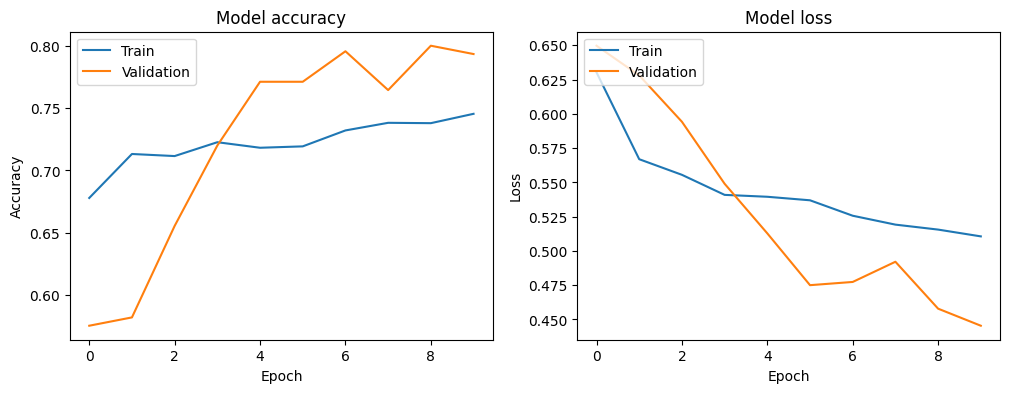

In [25]:
# Model Accuracy and Loss During Training

plt.figure(figsize=(12, 4))

# Accuracy curve
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss curve
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 702ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


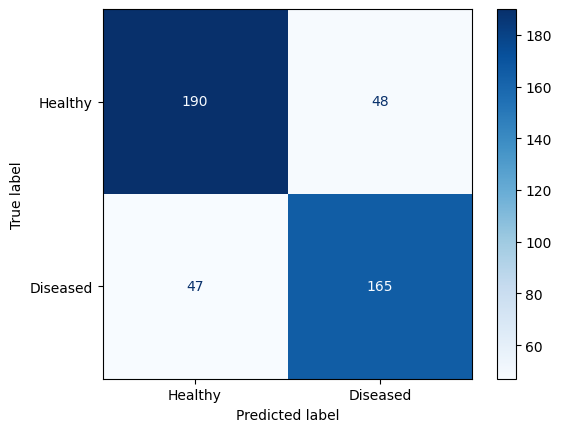

In [26]:
# Confusion matrix

y_true = []
y_pred = []

for image, label in test:
    y_true.extend(label.numpy())
    predictions = model3.predict(image)
    y_pred.extend(tf.round(predictions).numpy().flatten())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Diseased'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 934ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 998ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


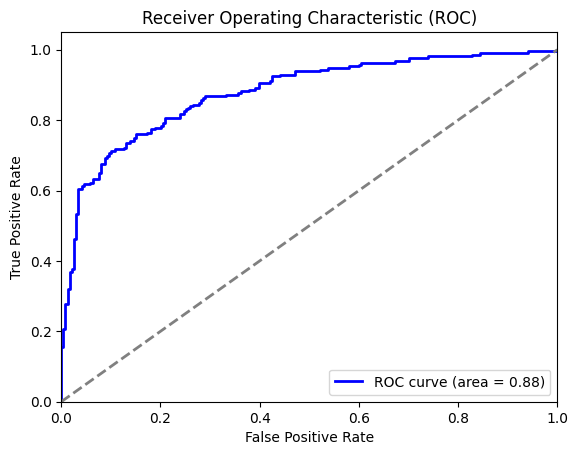

In [27]:
# ROC and AUC

y_true = []
y_pred_prob = []

for image, label in test:
    y_true.extend(label.numpy())
    predictions = model3.predict(image)
    y_pred_prob.extend(predictions.flatten())

# Compute ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Ensemble Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step


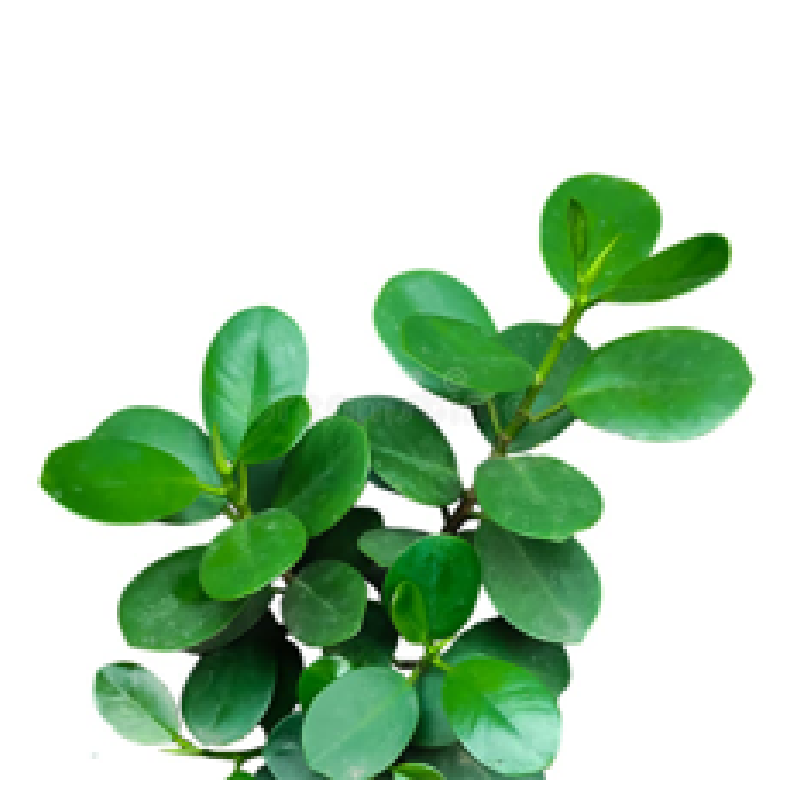

('Healthy', <Figure size 1000x1000 with 1 Axes>)

In [33]:
def predict_disease_ensemble(image_source):
  # Check if image_source is a URL or a local path
  if image_source.startswith('http'):
      image_path = download_image(image_source)
      if image_path is None:
          return None
  else:
      image_path = image_source

  # Load the image and preprocess it
  img = Image.open(image_path).convert('RGB')
  img = img.resize((224, 224))
  img = keras.preprocessing.image.img_to_array(img)
  img = img / 255
  img = tf.keras.applications.mobilenet_v3.preprocess_input(img)
  img = tf.expand_dims(img, axis=0)

  # Make the prediction
  pred1 = model1.predict(img)[0][0]
  class1 = 'Healthy' if pred1 < 0.5 else 'Diseased'
  pred2 = model2.predict(img)[0][0]
  class2 = 'Healthy' if pred2 < 0.5 else 'Diseased'
  img = Image.open(image_path).convert('RGB')
  img = img.resize((300, 300))
  img = keras.preprocessing.image.img_to_array(img)
  img = img / 255
  img = tf.keras.applications.mobilenet_v3.preprocess_input(img)
  img = tf.expand_dims(img, axis=0)
  pred3 = model3.predict(img)[0][0]
  class3 = 'Healthy' if pred2 < 0.5 else 'Diseased'

  predicted_class = 'Diseased' if pred1 + pred2 + pred3 >= 2 else 'Healthy'

  img = Image.open(image_path).convert('RGB')
  img = img.resize((224, 224))
  plot = plt.figure(figsize=(10, 10))
  plt.imshow(img)
  plt.axis("off")
  plt.show()
  if image_source.startswith('http'):
        os.remove(image_path)

  return predicted_class, plot
predict_disease_ensemble("https://thumbs.dreamstime.com/b/green-leaves-plant-transparent-background-close-photo-tree-leaf-brush-white-316504945.jpg")

In [34]:
demo = gradio.Interface(
    fn = predict_disease_ensemble,
    inputs = ["text"],
    outputs = ["text", "plot"]
)
demo.launch()

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
